In [2]:
import symmetrize
symmetrize.__version__

'0.5.5'

In [3]:
import numpy as np
from symmetrize import sym, pointops as po
import scipy.io as sio
import matplotlib.pyplot as plt

### 1. Load data

In [4]:
fpath = r'..\resources\data\WSe2_data.mat'

In [5]:
data = sio.loadmat(fpath)['data']
data.shape

(4, 100, 100)

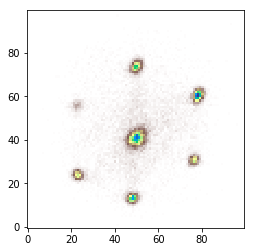

In [6]:
# Select an energy slice with sharp features as the image for transform estimation
Eslice = data[0,...]
plt.imshow(Eslice, origin='lower', cmap='terrain_r')

### 2. Determine landmarks

In [7]:
# Detect peaks as landmarks
pks = po.peakdetect2d(Eslice, method='daofind', fwhm=8)

# Select the center from the set of landmarks and separate from the vertices
pcent, psur = po.pointset_center(pks, method='centroidnn')

# Order the point set in counterclockwise fashion
psur_ord = po.pointset_order(psur, direction='ccw')

In [8]:
# Alternatively, use pointset_locate() to combine the three operations.
# pcent, psur_ord = po.pointset_locate(Eslice, method='daofind', centermethod='centroidnn', direction='ccw', fwhm=8)

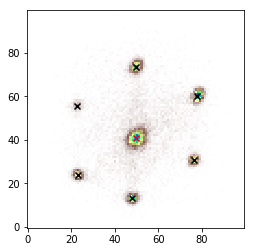

In [9]:
# View the points labelled on top of the image
plt.imshow(Eslice, origin='lower', cmap='terrain_r')
plt.scatter(psur_ord[:,1], psur_ord[:,0], c='k', marker='x')
plt.scatter(pcent[1], pcent[0], c='r', marker='x')

### 3. Determine the coordinate transform matrix using iterative optimization
#### 3.1 Transform matrix for nonrigid distortion correction

In [10]:
# Calculate the mean center-vertex distance (mcvd)
mcvd = po.cvdist(psur_ord, pcent).mean()

# Calculate the mean vertex-vertex distance (mvvd) or mean edge distance
mvvd = po.vvdist(psur_ord).mean()

In [11]:
# Set up the initial conditions
init = np.asarray([[0, 60, 60., 60., 60, 60], [1.0]*6]).ravel()

# Optimize for a better target point set
psur_tg, _ = sym.target_set_optimize(init, psur_ord, tuple(pcent), mcvd, mvvd, direction=-1, \
                        weights=(5, 1, 5), optfunc='minimize', optmethod='Nelder-Mead')

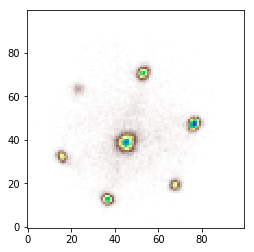

In [12]:
# Use optimized target point set to calculate the projective transform
Eslice_warped, H = sym.imgWarping(Eslice, landmarks=psur_ord, targs=psur_tg)
plt.imshow(Eslice_warped, origin='lower', cmap='terrain_r')

#### 3.2 Transform matrix for rigid pose adjustment (optional)

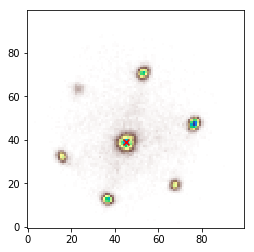

In [13]:
# Detect the position of the new center
pcent2, _ = po.pointset_locate(Eslice_warped, method='daofind', centermethod='centroidnn', direction='ccw', fwhm=8)

plt.imshow(Eslice_warped, origin='lower', cmap='terrain_r')
plt.scatter(pcent2[1], pcent2[0], c='r', marker='x')

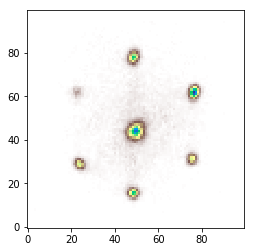

In [14]:
# Combine consecutive geometric transforms
rotM = sym.rotation2D(-16, center=pcent2)
transM = sym.translation2D(xtrans=5, ytrans=4)
M = np.linalg.multi_dot([H, rotM, transM])

# Apply the combined transform to an image
Eslice_warped, _ = sym.imgWarping(Eslice, hgmat=M)
plt.imshow(Eslice_warped, origin='lower', cmap='terrain_r')

### 4. Apply the coordinate transform to images in the same series

In [15]:
data_warped = sym.applyWarping(data, axis=0, warptype='matrix', hgmat=M)

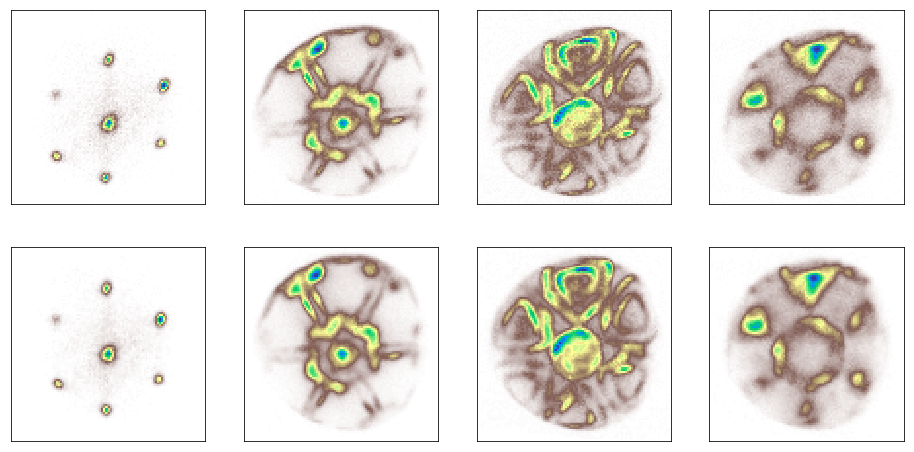

In [16]:
# Visualize the images before and after applying the transform
f, ax = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    ax[0,i].imshow(data[i,...], origin='lower', cmap='terrain_r')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    
    ax[1,i].imshow(data_warped[i,...], origin='lower', cmap='terrain_r')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])